## Predicciones en el Mercado Inmobiliario de Dinamarca

#### 1. Análisis exploratorio de los datos analizando las diferentes regiones, precios, tamaños, características, tipos... a lo largo de los años.

#### 2. Predicciones sobre las futuras ventas de casas, precios según las regiones, tamaños y tipos de casa predominante.

## 1. EDA

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [67]:
#Cargar csv
df_houses = pd.read_csv('houses.csv')
#Filtro para solo años por encima de 1800
df_houses_year = df_houses[df_houses['year_build'] > 1800]

### Limpieza de datos

In [68]:
#Eliminar columnas sin interés
columns_to_drop = ['yield_on_mortgage_credit_bonds%']
df_houses = df_houses.drop(columns=columns_to_drop)

In [69]:
# Contar el número de filas duplicadas
num_duplicates = df_houses.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 0


In [70]:
# Encontrar filas duplicadas
filas_duplicadas = df_houses[df_houses.duplicated()]

In [71]:
def valores_faltantes(data):
  total = data.isnull().sum()
  porcentaje = (data.isnull().sum()/data.isnull().count()*100)
  tt = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
  types = []
  for col in data.columns:
    dtype = str(data[col].dtype)
    types.append(dtype)
  tt['Tipos'] = types
  return np.transpose(tt)

valores_faltantes(df_houses)

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,77
Porcentaje,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011,0.0,0.0,0.0,0.077
Tipos,object,object,int64,object,object,int64,int64,float64,int64,float64,float64,object,int64,object,object,object,float64,float64


In [72]:
df_houses['city'].unique()

array(['Solrød Strand', 'Frederiksberg C', 'Kalundborg', 'Farum',
       'Svendborg', 'Skovlunde', 'Erslev', 'Branderup J', 'Holsted',
       'Esbjerg', 'Jægerspris', 'Silkeborg', 'Snertinge', 'Agedrup',
       'Hornbæk', 'Sønderborg', 'Aabenraa', 'Fredericia', 'Roskilde',
       'Alsted', 'Aarhus C', 'Odense C', 'Ikast', 'Aars', 'Barrit',
       'Faxe', 'Sjællands Odde', 'Hurup Thy', 'Valby', 'Humlebæk',
       'Slagelse', 'Vig', 'Charlottenlund', 'Greve', 'Odense N',
       'Store Fuglede', 'Ringsted', 'Idestrup', 'Skødstrup',
       'Nykøbing Sj', 'København N', 'Karby', 'Faaborg', 'Ã\x85lsgårde',
       'Lemvig', 'Ansager', 'Gjerlev J', 'Hørsholm', 'Assens',
       'Vordingborg', 'Aulum', 'Ebeltoft', 'Bogense', 'Løgstrup',
       'Glostrup', 'Skive', 'Fuglebjerg', 'Astbirk', 'Rødekro', 'Malling',
       'Randers NV', 'Ringkøbing', 'Herning', 'Arbæk', 'Brovst', 'Søborg',
       'Fanø', 'Gentofte', 'Hedehusene', 'Aalborg', 'Tarm', 'Sunds',
       'Helsinge', 'Mørkøv', 'Nexø', 'Højsle

In [73]:
df_houses.head()

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%
0,2024-10-24,2024Q4,16,Villa,regular_sale,1997,6500000,-3.0,5,142.0,45774.650,Spættevej 16,2680,Solrød Strand,"Capital, Copenhagen",Zealand,3.1,NaN
1,2024-10-24,2024Q4,13,Apartment,regular_sale,1885,3400000,0.0,2,46.0,73913.050,"Jakob Dannefærds Vej 10B, 4. th",1973,Frederiksberg C,"Capital, Copenhagen",Zealand,3.1,NaN
2,2024-10-23,2024Q4,60,Villa,regular_sale,1949,4550000,-4.0,4,112.0,40625.000,Vestre Plantagevej 3,2680,Solrød Strand,"Capital, Copenhagen",Zealand,3.1,NaN
3,2024-10-23,2024Q4,29,Villa,regular_sale,2001,1630000,-12.0,4,186.0,8763.440,Toftebjerg 3,4400,Kalundborg,Other islands,Zealand,3.1,NaN
4,2024-10-22,2024Q4,92,Apartment,regular_sale,1965,1975000,-10.0,3,82.0,24085.365,"Ryttergårdsvej 20, 1. 113",3520,Farum,North Zealand,Zealand,3.1,NaN


### Comparar precios a lo largo del tiempo según tipo de casa

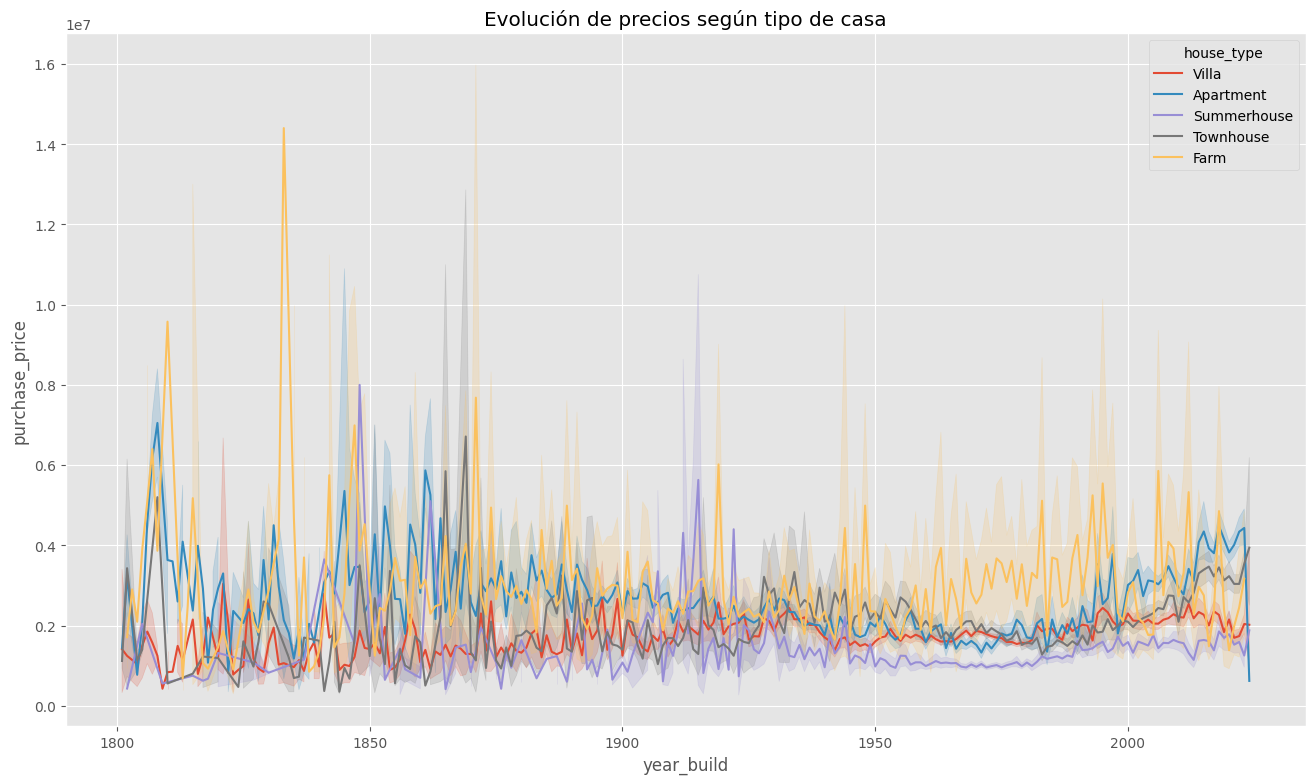

In [74]:
#Gráfico de evolución de precios según house_type
sns.lineplot(x='year_build', y='purchase_price', data=df_houses_year, hue='house_type')
plt.title('Evolución de precios según tipo de casa')
plt.show()

### Comparar los precios según región a lo largo del tiempo

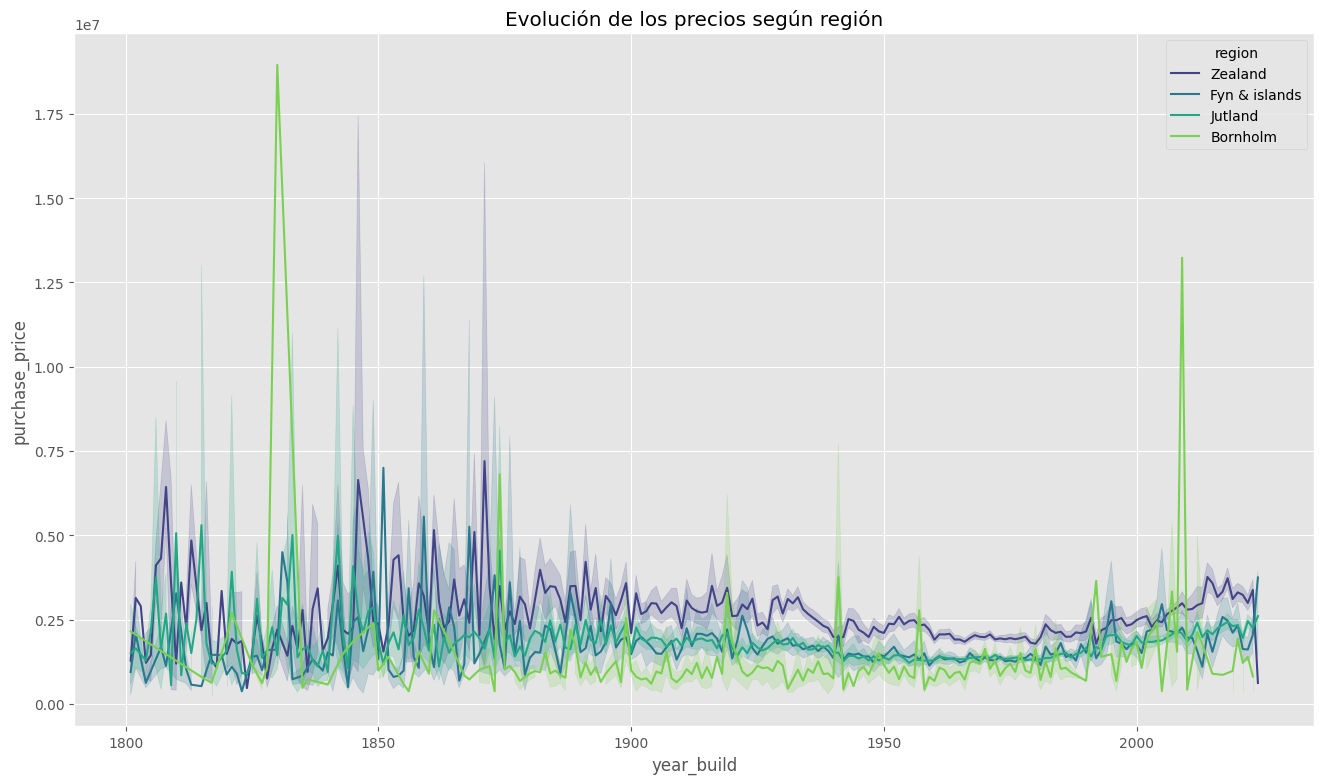

In [75]:
# Gráfico de la evolución de los precios según region
plt.figure(figsize=(16, 9))
sns.lineplot(x='year_build', y='purchase_price', data=df_houses_year, hue='region', palette='viridis')
plt.title('Evolución de los precios según región')
plt.show()

### Comparar tamaño y precio según región

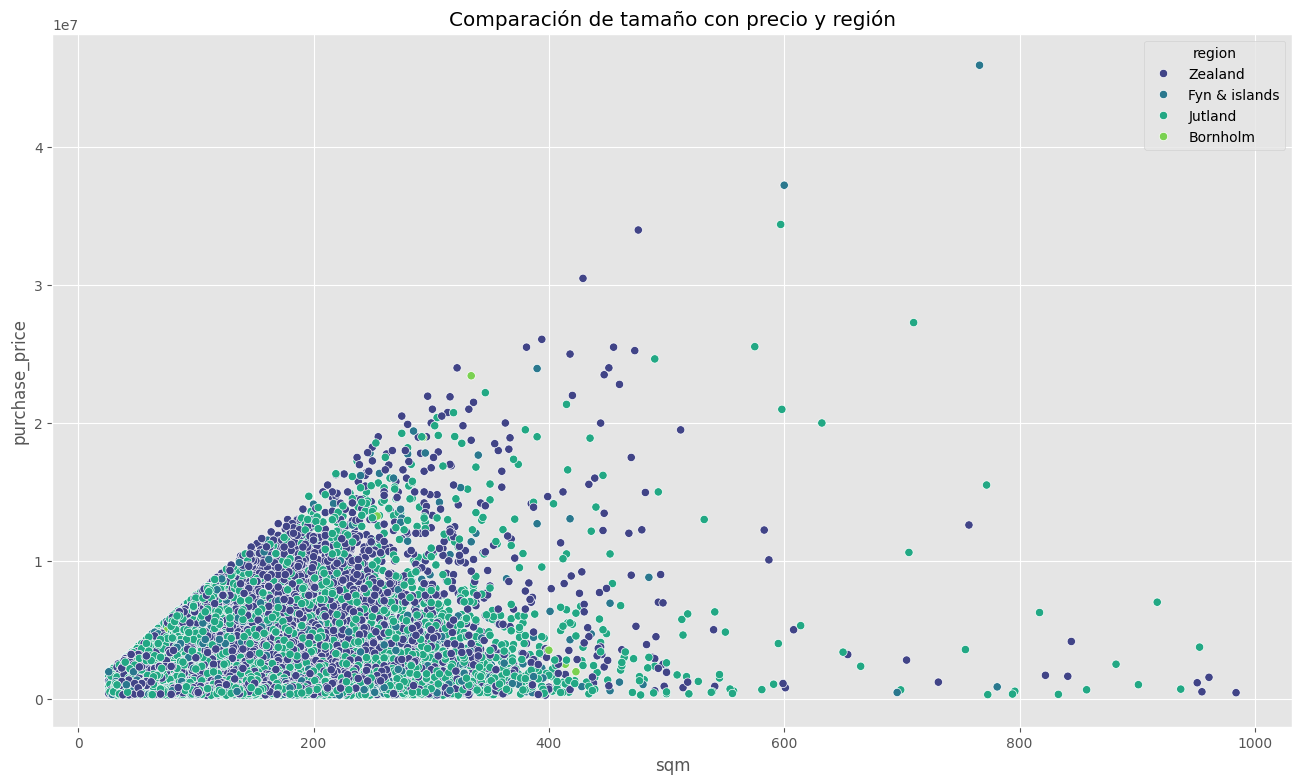

In [76]:
# Gráfico para comparar sqm con purchase_price y region
plt.figure(figsize=(16, 9))
sns.scatterplot(x='sqm', y='purchase_price', data=df_houses, hue='region', palette='viridis')
plt.title('Comparación de tamaño con precio y región')
plt.show()

### Comparar Precio y tamaño a lo largo de los años

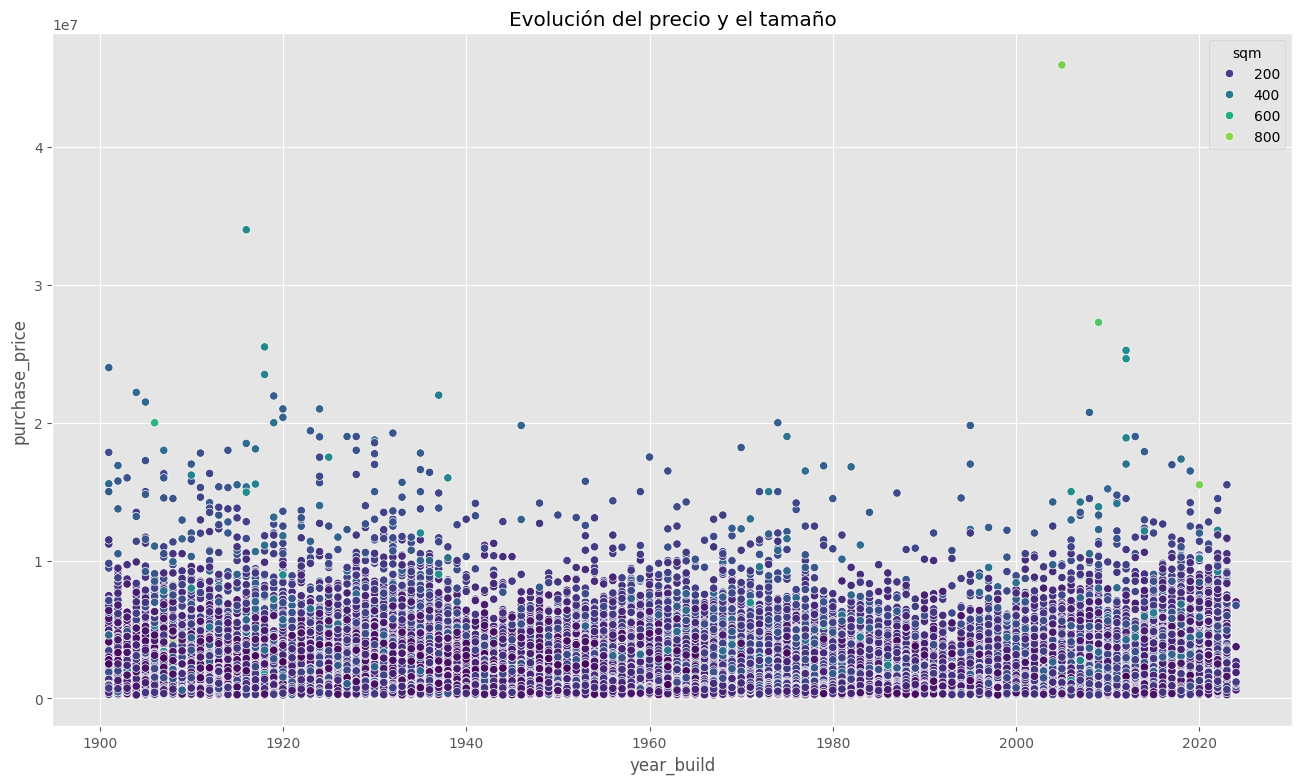

In [77]:
#Filtro para solo años por encima de 1900
df_houses_1900 = df_houses[df_houses['year_build'] > 1900]
#Gráfico para comparar year_build con purchase_price y sqm
plt.figure(figsize=(16, 9))
sns.scatterplot(x='year_build', y='purchase_price', data=df_houses_1900, hue='sqm', palette='viridis')
plt.title('Evolución del precio y el tamaño')
plt.show()

### Evolución de tipos de casa en cada región

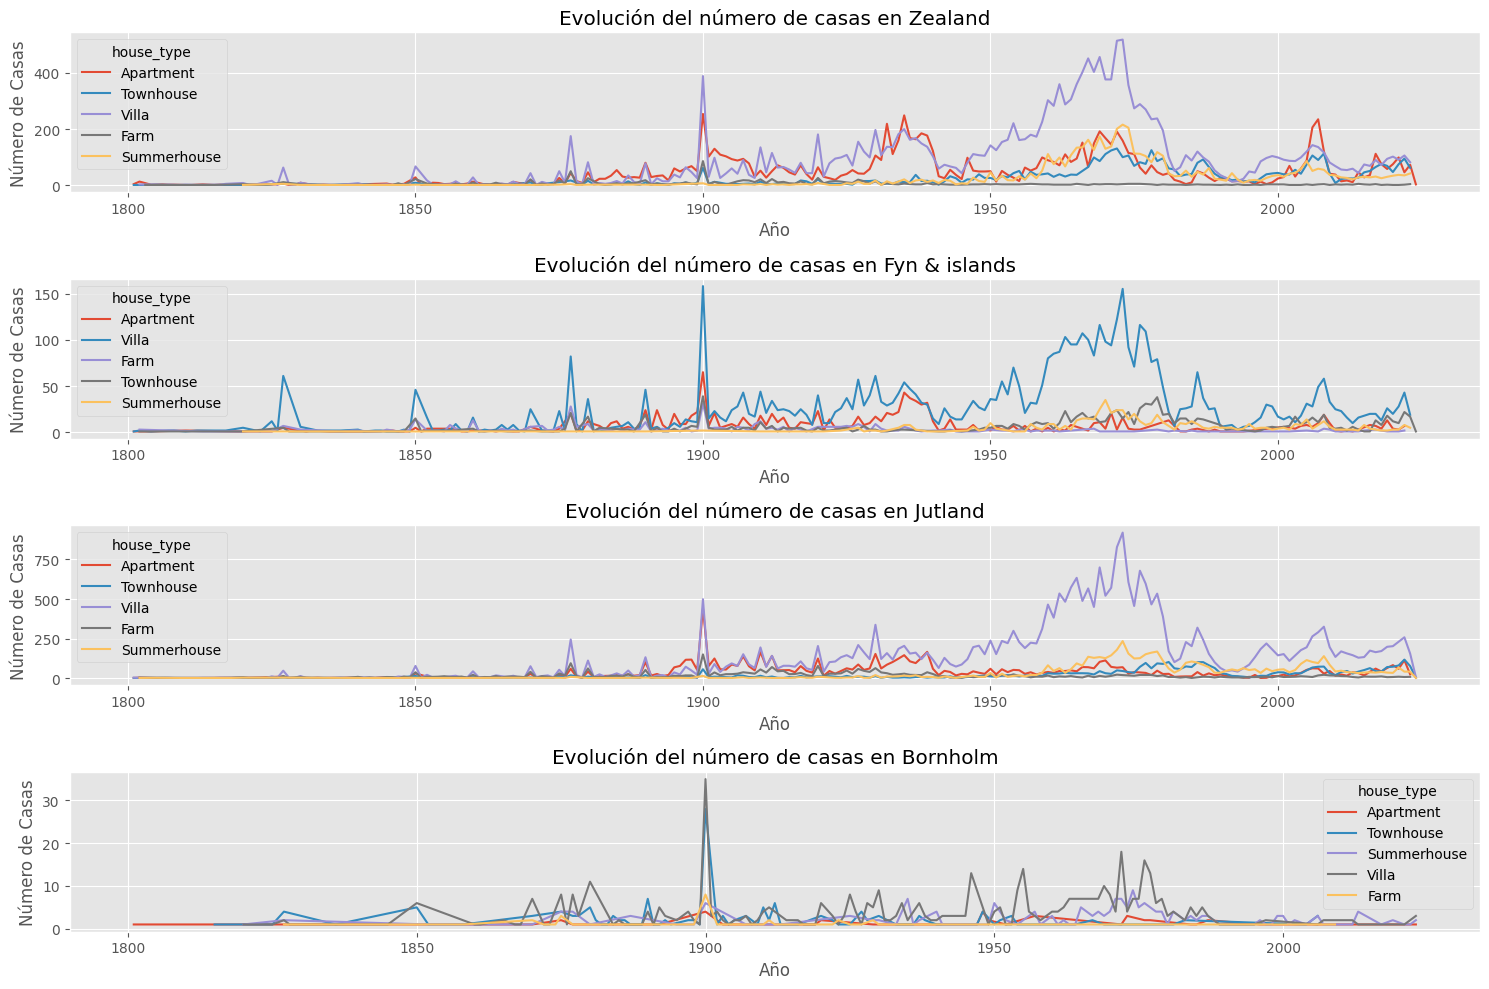

In [78]:
# funcion para contar
def contar(data, column1, column2):
  df = data.groupby(['year_build', column1, column2]).size().reset_index(name='counts')
  return df

# Crear el gráfico
plt.figure(figsize=(15, 10))

# Obtener las regiones únicas
regiones = df_houses_year['region'].unique()

# Crear un gráfico para cada región
for i, region in enumerate(regiones):
    df = contar(df_houses_year, 'region', 'house_type')
    plt.subplot(len(regiones), 1, i + 1)
    region_data = df[df['region'] == region]
    sns.lineplot(data=region_data, x='year_build', y='counts', hue='house_type')
    plt.title(f'Evolución del número de casas en {region}')
    plt.xlabel('Año')
    plt.ylabel('Número de Casas')

plt.tight_layout()
plt.show()

### Evolución de casas según región

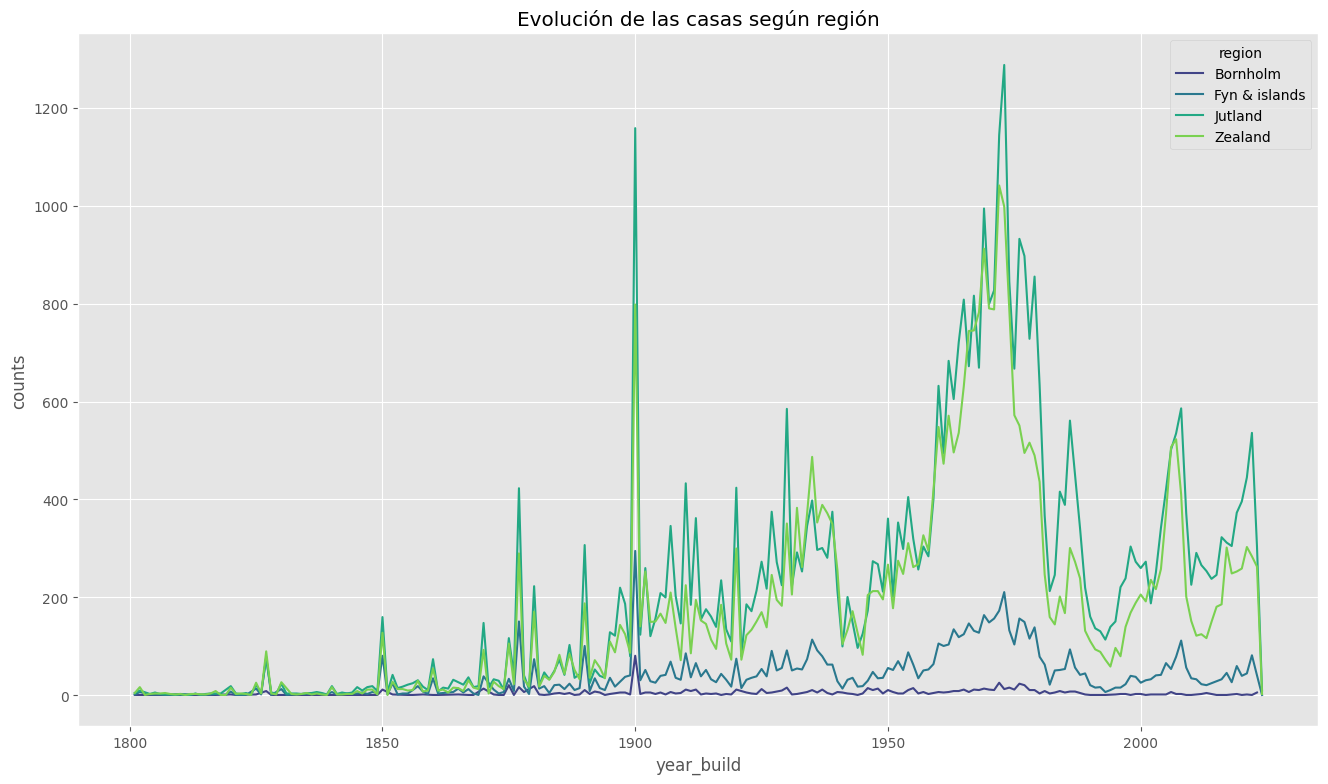

In [79]:
# funcion para contar solo una columna
def contar_una(data, column1):
  df = data.groupby(['year_build', column1]).size().reset_index(name='counts')
  return df

# Gráfico Evolución de número de casas según región a lo largo de los años
df = contar_una(df_houses_year, 'region')
plt.figure(figsize=(16, 9))
sns.lineplot(x='year_build', y='counts', data=df, hue='region', palette='viridis')
plt.title('Evolución de las casas según región')
plt.show()

### Evolución del número de habitaciones según región

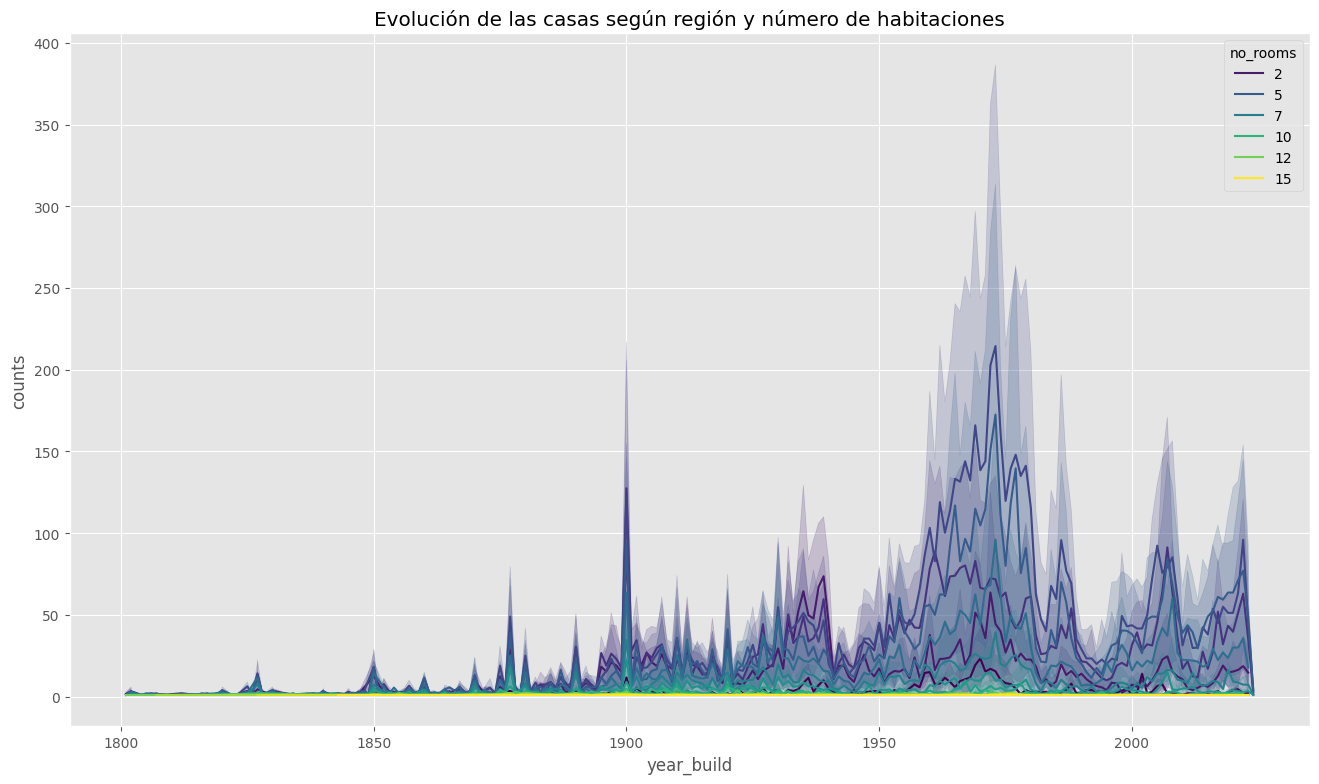

In [80]:
# gráfico Evolución del número de casas con diferente numero de habitaciones según región a lo largo de los años
df = contar(df_houses_year, 'region', 'no_rooms')
plt.figure(figsize=(16, 9))
sns.lineplot(x='year_build', y='counts', data=df, hue='no_rooms', palette='viridis')
plt.title('Evolución de las casas según región y número de habitaciones')
plt.show()

## 2. Predicciones Sobre Futuras Construcciones

### Precios por región en los próximos años

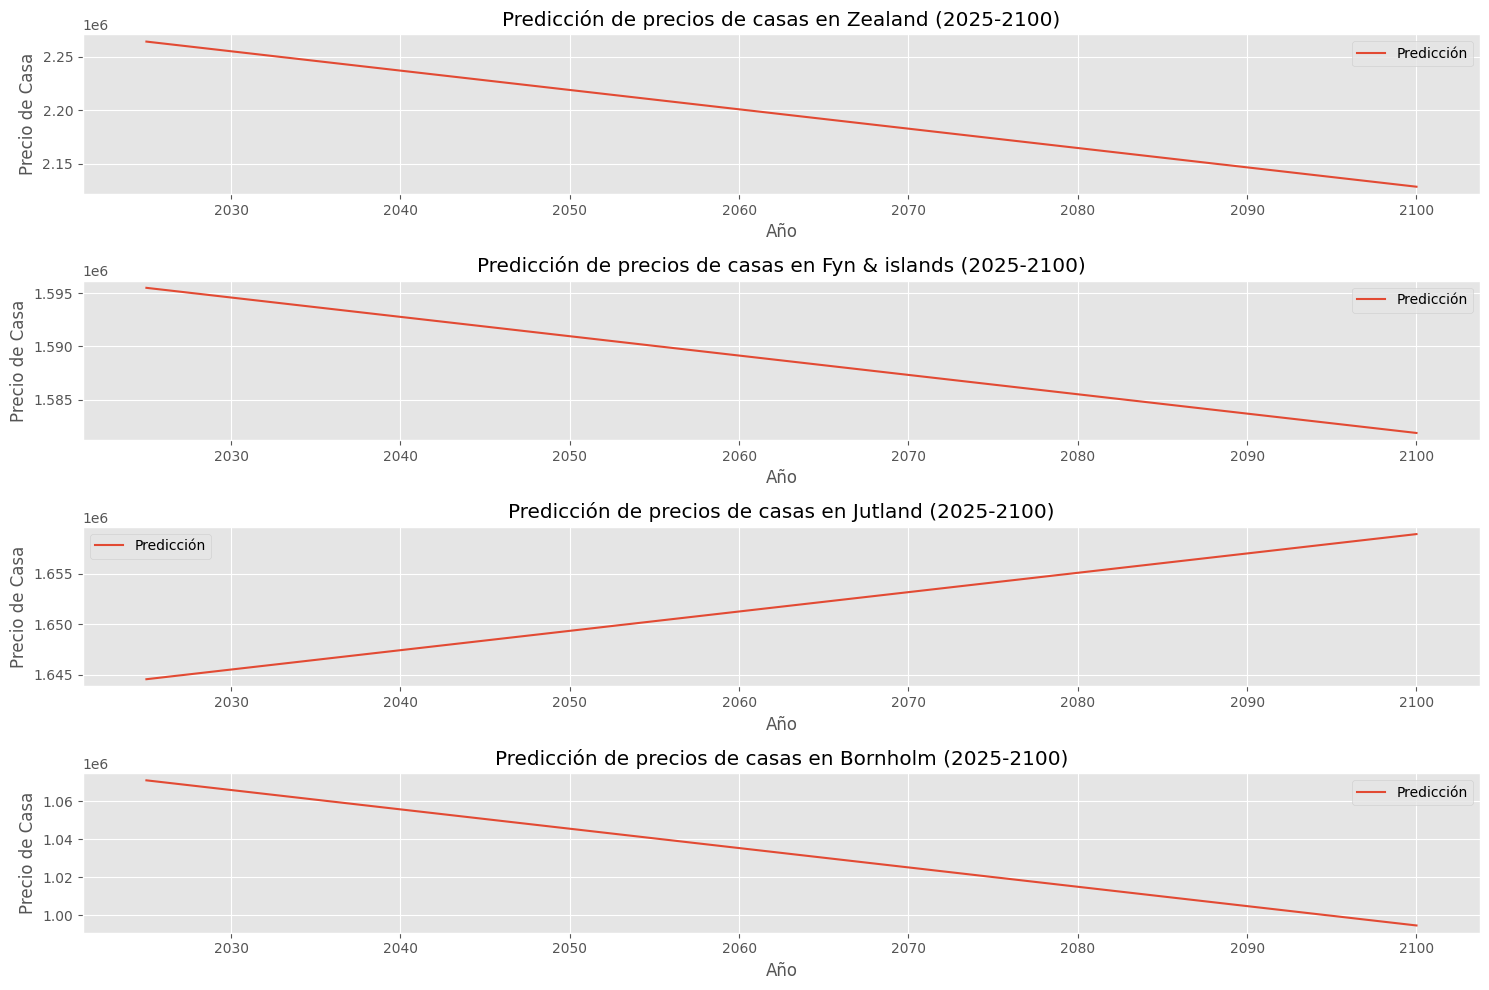

In [81]:
# Crear un modelo de regresión lineal para cada región
regiones = df_houses['region'].unique()
predicciones = {}

for region in regiones:
    region_data = df_houses[df_houses['region'] == region]
    X = region_data[['year_build']]
    y = region_data['purchase_price']
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predecir los precios de 2025 a 2100
    future_years = pd.DataFrame(np.arange(2025, 2101), columns=['year_build'])
    future_prices = model.predict(future_years)
    
    predicciones[region] = (future_years['year_build'].values, future_prices)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    years, prices = predicciones[region]
    plt.plot(years, prices, label='Predicción')
    plt.title(f'Predicción de precios de casas en {region} (2025-2100)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de la evolución de precios con variables macroeconómicas de interés e inflación

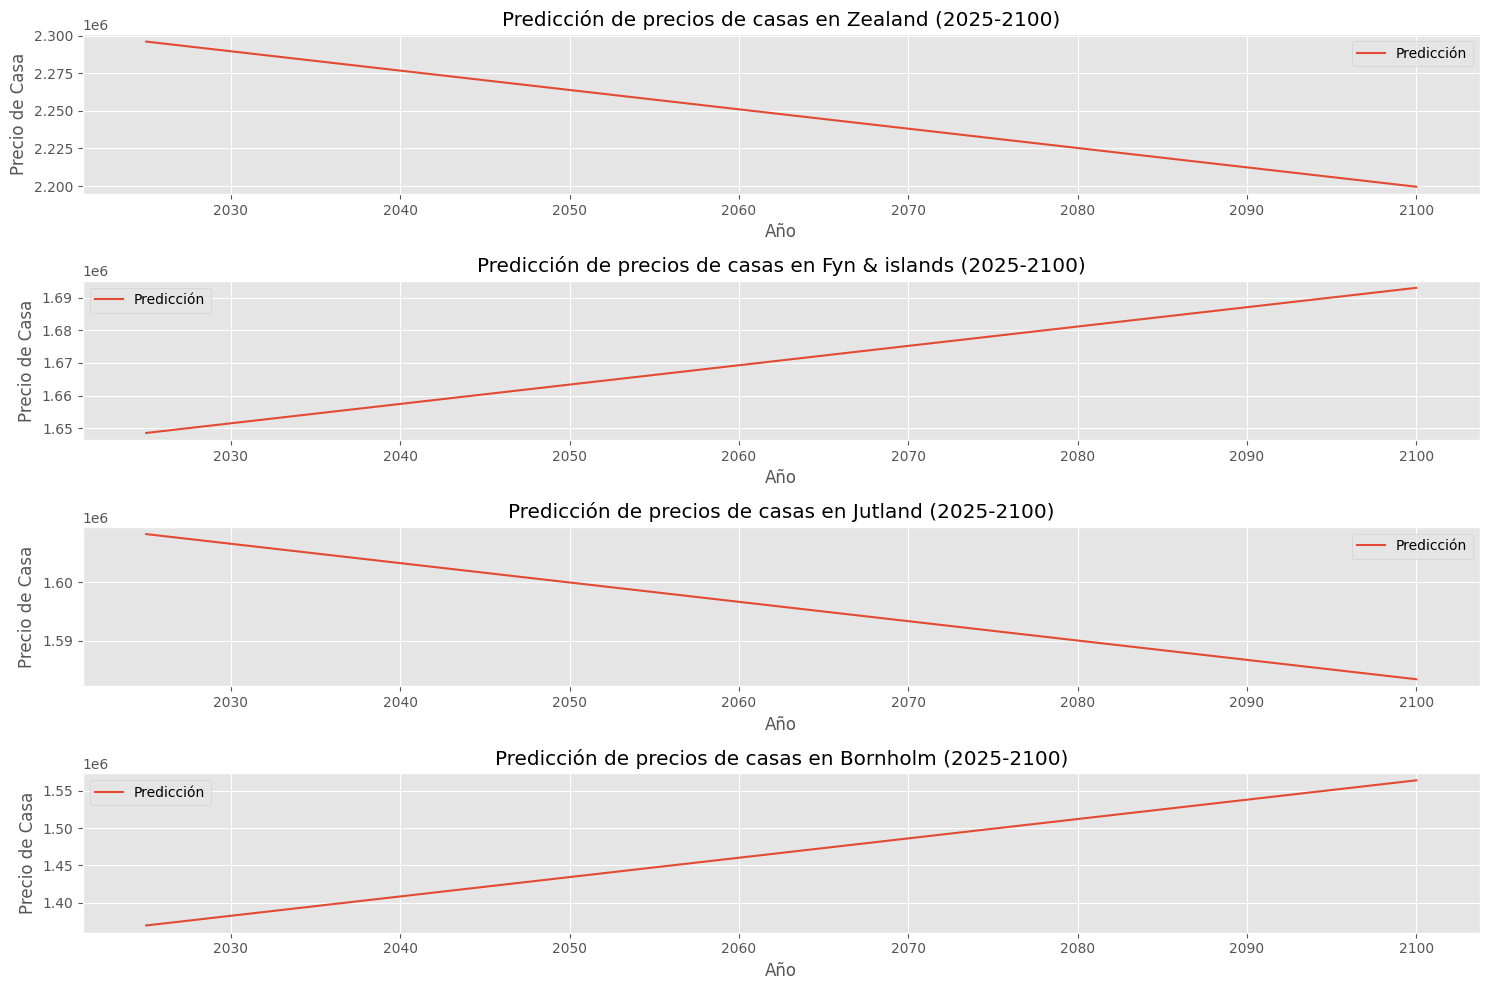

In [96]:
regiones = df_houses['region'].unique()
predicciones = {}

for region in regiones:
    region_data = df_houses[df_houses['region'] == region]
    # Incluimos más variables predictoras
    X = region_data[['year_build', 'no_rooms', 'sqm', 'nom_interest_rate%', 'dk_ann_infl_rate%']]
    y = region_data['purchase_price']
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predecir los precios de 2025 a 2100
    future_years = np.arange(2025, 2101)
    future_data = pd.DataFrame({
        'year_build': future_years,
        'no_rooms': np.mean(region_data['no_rooms']),
        'sqm': np.mean(region_data['sqm']),
        'nom_interest_rate%': np.mean(region_data['nom_interest_rate%']),
        'dk_ann_infl_rate%': np.mean(region_data['dk_ann_infl_rate%'])
    })
    
    future_prices = model.predict(future_data)
    
    predicciones[region] = (future_years, future_prices)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    years, prices = predicciones[region]
    plt.plot(years, prices, label='Predicción')
    plt.title(f'Predicción de precios de casas en {region} (2025-2100)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()

### Tipos de casa por región en los próximos años

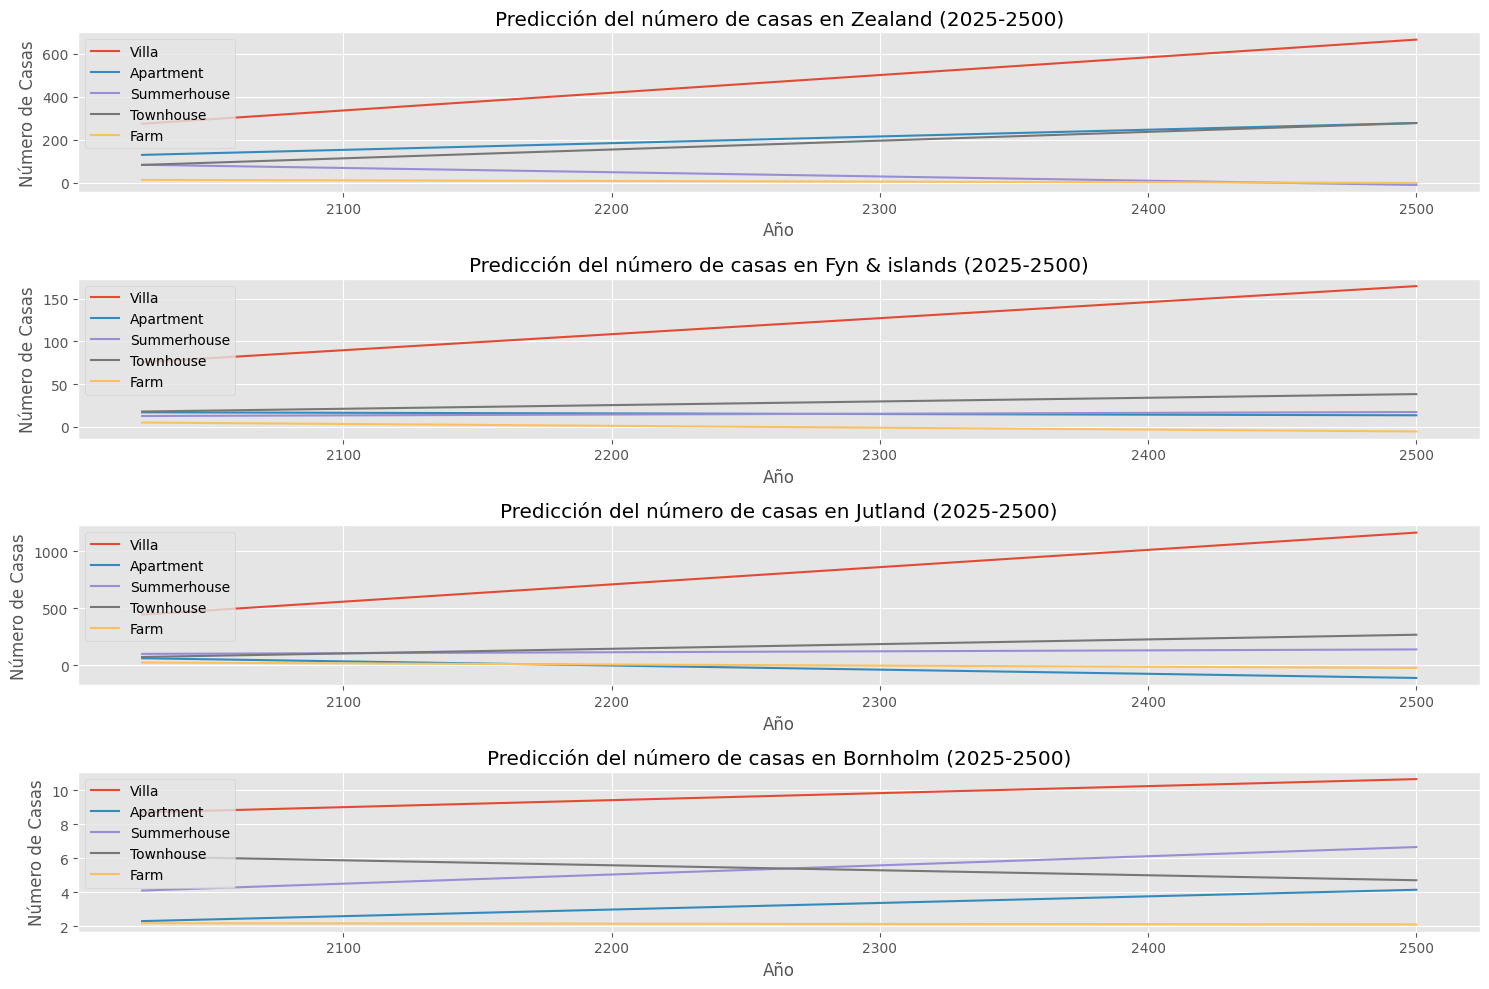

In [83]:
# Contar el número de casas por año, región y tipo de casa
df_houses['Numero_de_Casas'] = df_houses.groupby(['year_build', 'region', 'house_type'])['house_id'].transform('count')

# Crear un modelo de regresión lineal para cada tipo de casa en cada región
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        X = region_tipo_data[['year_build']]
        y = region_tipo_data['Numero_de_Casas']
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Predecir el número de casas de 2025 a 2500
        future_years = pd.DataFrame(np.arange(2025, 2501), columns=['year_build'])
        future_casas = model.predict(future_years)
        
        predicciones[region][tipo] = (future_years['year_build'].values, future_casas)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        years, casas = predicciones[region][tipo]
        plt.plot(years, casas, label=tipo)
    plt.title(f'Predicción del número de casas en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Número de Casas')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de los precios según tipo de casa por región

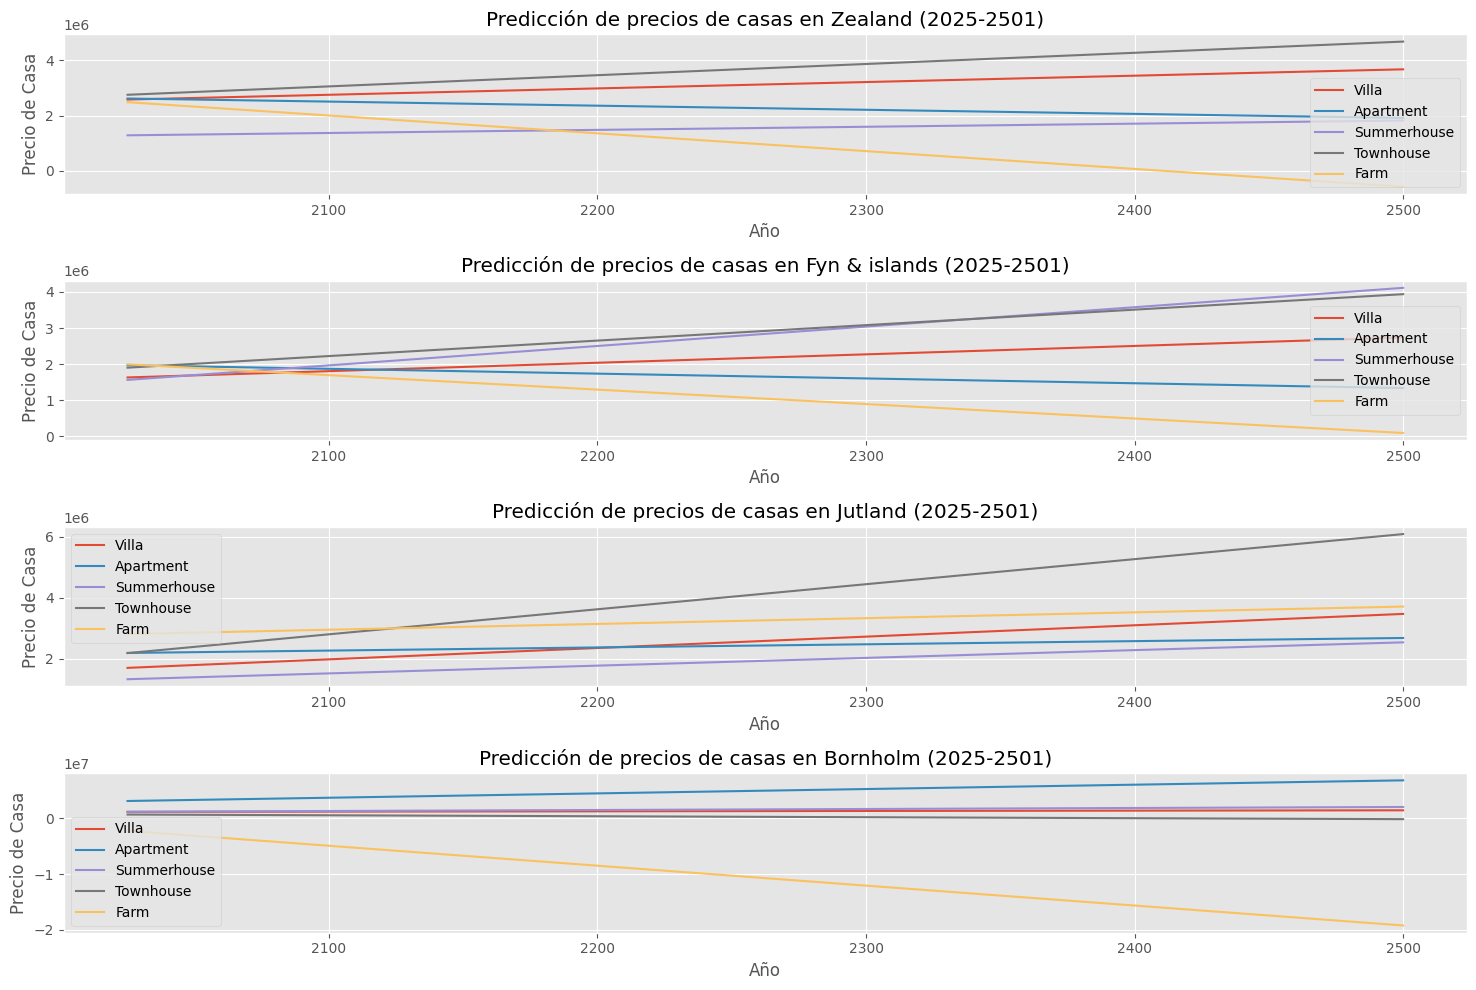

In [84]:
# Crear un modelo de regresión lineal para cada tipo de casa en cada región
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        X = region_tipo_data[['year_build']]
        y = region_tipo_data['purchase_price']
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Predecir los precios de 2025 a 2500
        future_years = pd.DataFrame(np.arange(2025, 2501), columns=['year_build'])
        future_precios = model.predict(future_years)
        
        predicciones[region][tipo] = (future_years['year_build'].values, future_precios)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        years, precios = predicciones[region][tipo]
        plt.plot(years, precios, label=tipo)
    plt.title(f'Predicción de precios de casas en {region} (2025-2501)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de los metros cuadrados por región y según tipo de casa

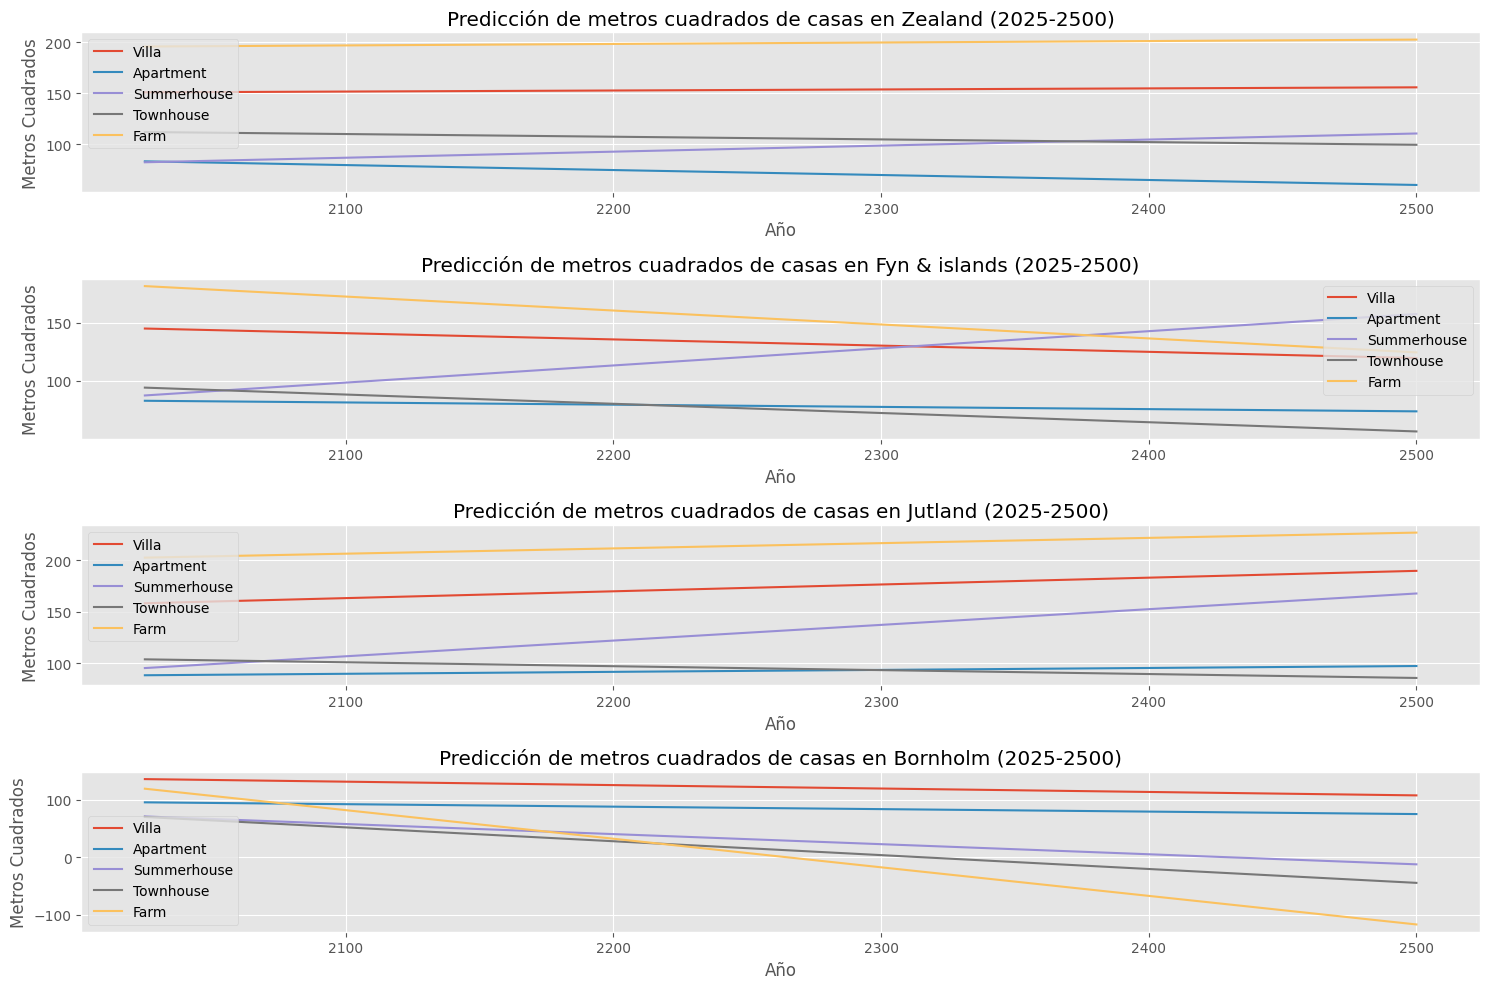

In [85]:
# Crear un modelo de regresión lineal para cada tipo de casa en cada región
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        X = region_tipo_data[['year_build']]
        y = region_tipo_data['sqm']
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Predecir los metros cuadrados de 2025 a 2500
        future_years = pd.DataFrame(np.arange(2025, 2501), columns=['year_build'])
        future_metros = model.predict(future_years)
        
        predicciones[region][tipo] = (future_years['year_build'].values, future_metros)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        years, metros = predicciones[region][tipo]
        plt.plot(years, metros, label=tipo)
    plt.title(f'Predicción de metros cuadrados de casas en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Metros Cuadrados')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción del precio según metros cuadrados por región y según tipo de casa

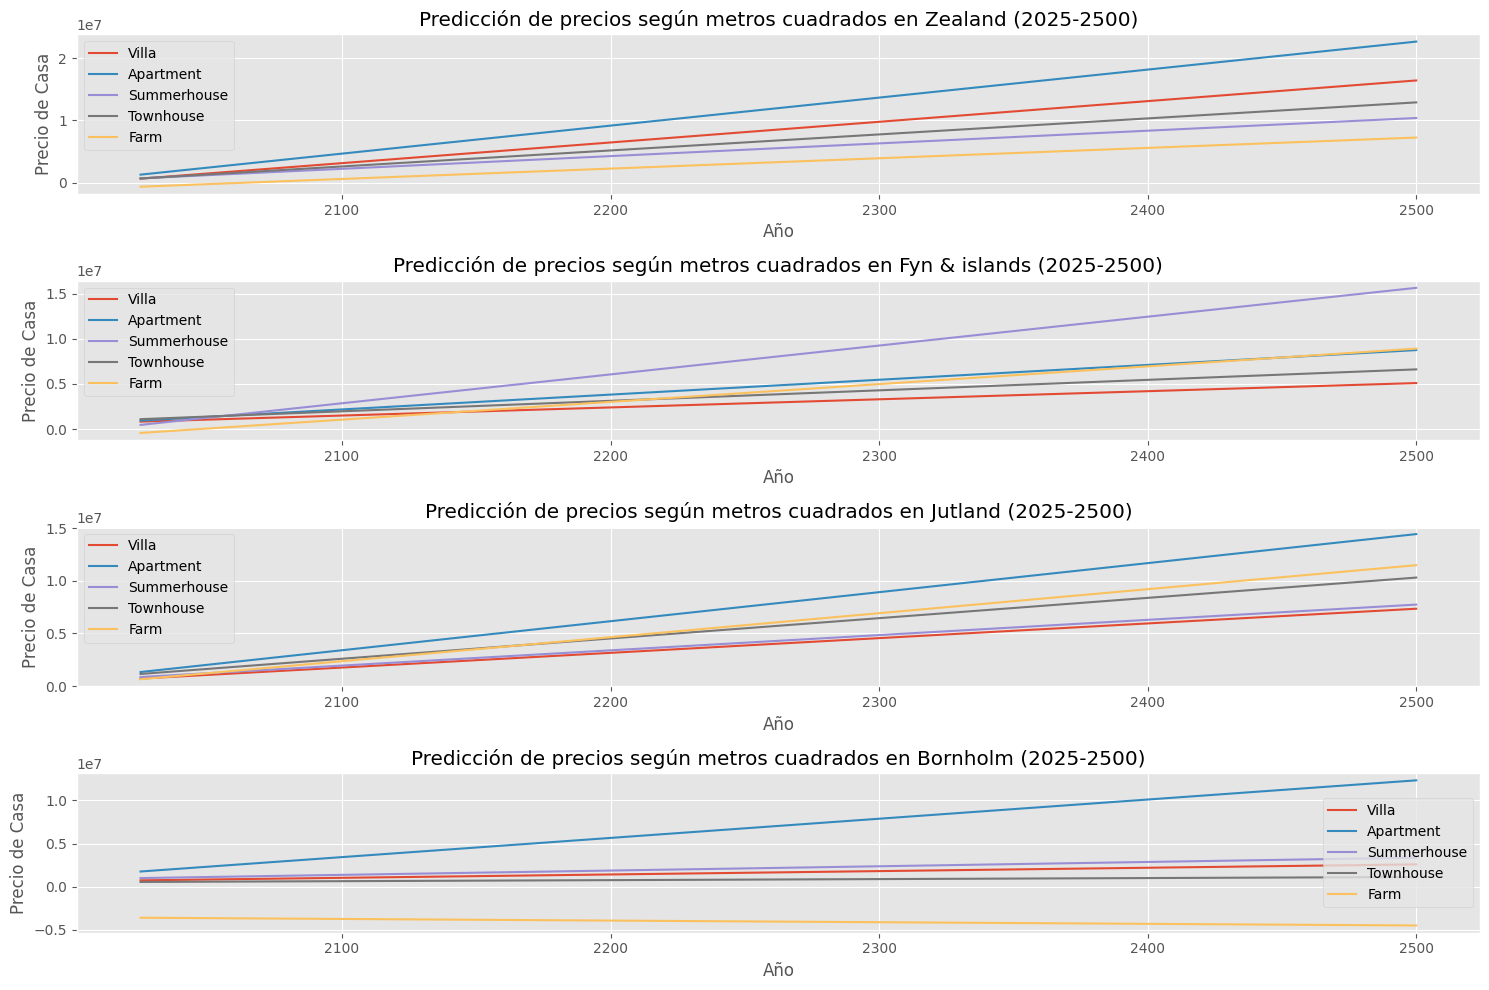

In [86]:
# Crear un modelo de regresión lineal para cada tipo de casa en cada región
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        X = region_tipo_data[['year_build', 'sqm']]
        y = region_tipo_data['purchase_price']
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Predecir los precios de 2025 a 2500
        future_years = np.arange(2025, 2501)
        future_metros = np.linspace(region_tipo_data['sqm'].min(), region_tipo_data['sqm'].max(), len(future_years))
        future_data = pd.DataFrame({'year_build': future_years, 'sqm': future_metros})
        future_precios = model.predict(future_data)
        
        predicciones[region][tipo] = (future_years, future_metros, future_precios)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        years, metros, precios = predicciones[region][tipo]
        plt.plot(years, precios, label=tipo)
    plt.title(f'Predicción de precios según metros cuadrados en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de número de casas según número de habitaciones por regiones y según tipo de casa

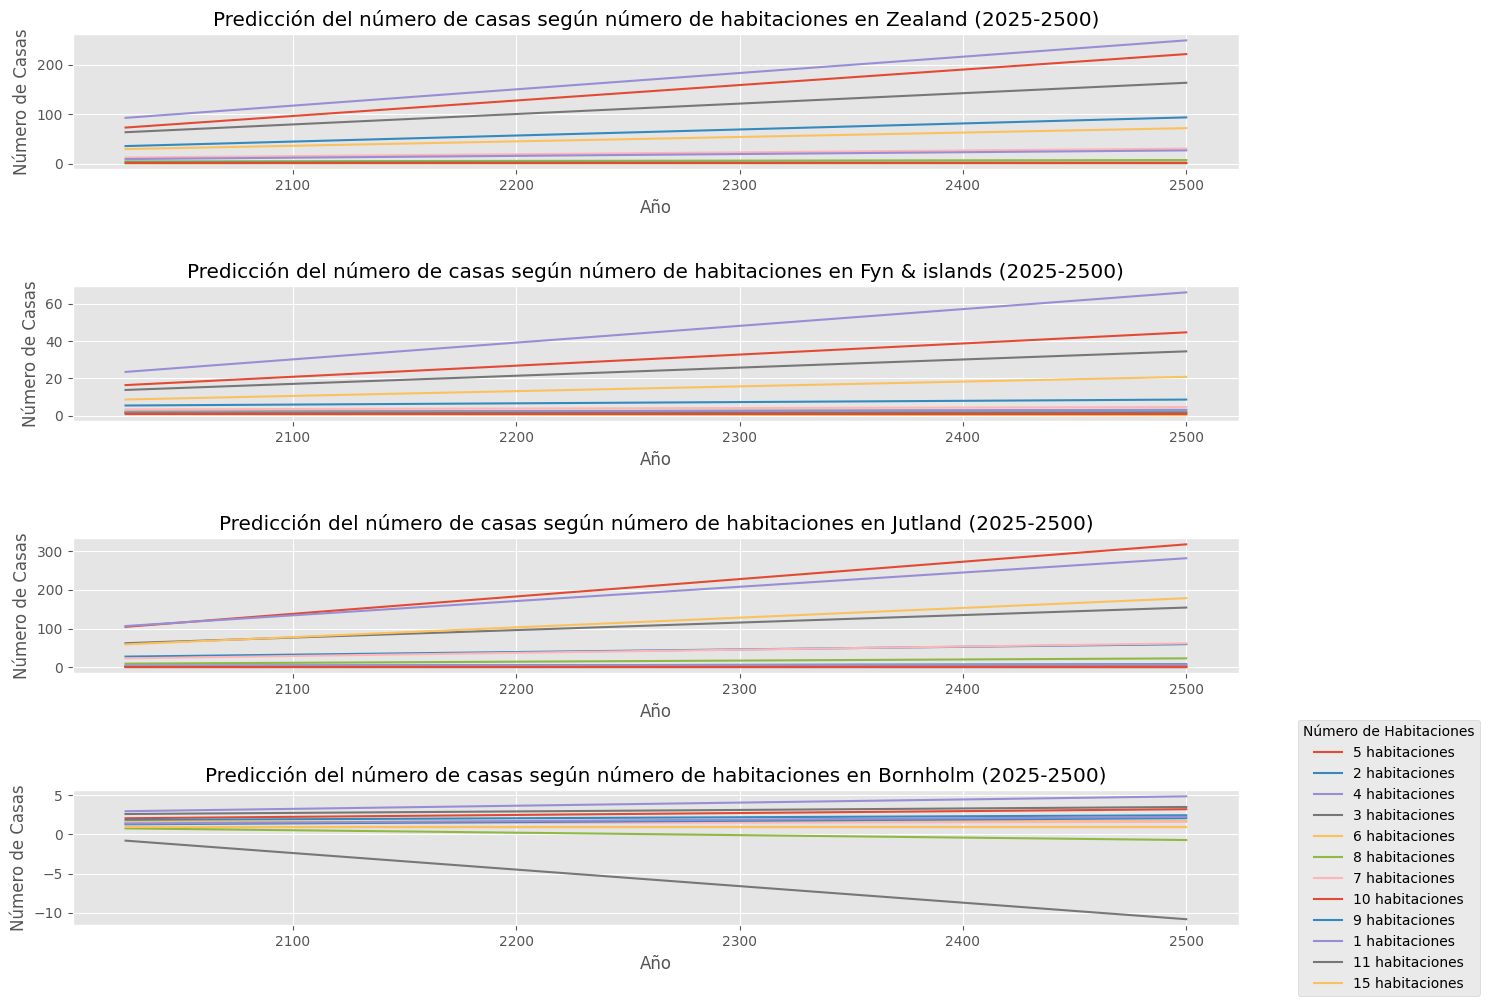

In [87]:
# Contar el número de casas para cada combinación de región y número de habitaciones
df_counts = df_houses.groupby(['year_build', 'region', 'no_rooms']).size().reset_index(name='num_houses')

# Crear un modelo de regresión lineal para cada combinación de región y número de habitaciones
regiones = df_houses['region'].unique()
num_habitaciones = df_houses['no_rooms'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for num_hab in num_habitaciones:
        region_hab_data = df_counts[(df_counts['region'] == region) & (df_counts['no_rooms'] == num_hab)]
        if not region_hab_data.empty:
            X = region_hab_data[['year_build']]
            y = region_hab_data['num_houses']
            
            model = LinearRegression()
            model.fit(X, y)
            
            # Predecir el número de casas de 2025 a 2500
            future_years = pd.DataFrame(np.arange(2025, 2501), columns=['year_build'])
            future_houses = model.predict(future_years)
            
            predicciones[region][num_hab] = (future_years['year_build'].values, future_houses)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for num_hab in num_habitaciones:
        if num_hab in predicciones[region]:
            years, houses = predicciones[region][num_hab]
            plt.plot(years, houses, label=f'{num_hab} habitaciones')
    plt.title(f'Predicción del número de casas según número de habitaciones en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Número de Casas')

# Ajustar la leyenda para que esté en una sola columna
plt.legend(title='Número de Habitaciones', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0., ncol=1)

plt.tight_layout()
plt.show()

### Clasificación de viviendas con RandomForest

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     13295
           1       0.31      0.21      0.25      1882
           2       0.37      0.28      0.32      4823

    accuracy                           0.63     20000
   macro avg       0.47      0.44      0.45     20000
weighted avg       0.60      0.63      0.61     20000

Matriz de confusión:
[[10872   518  1905]
 [ 1018   404   460]
 [ 3084   377  1362]]


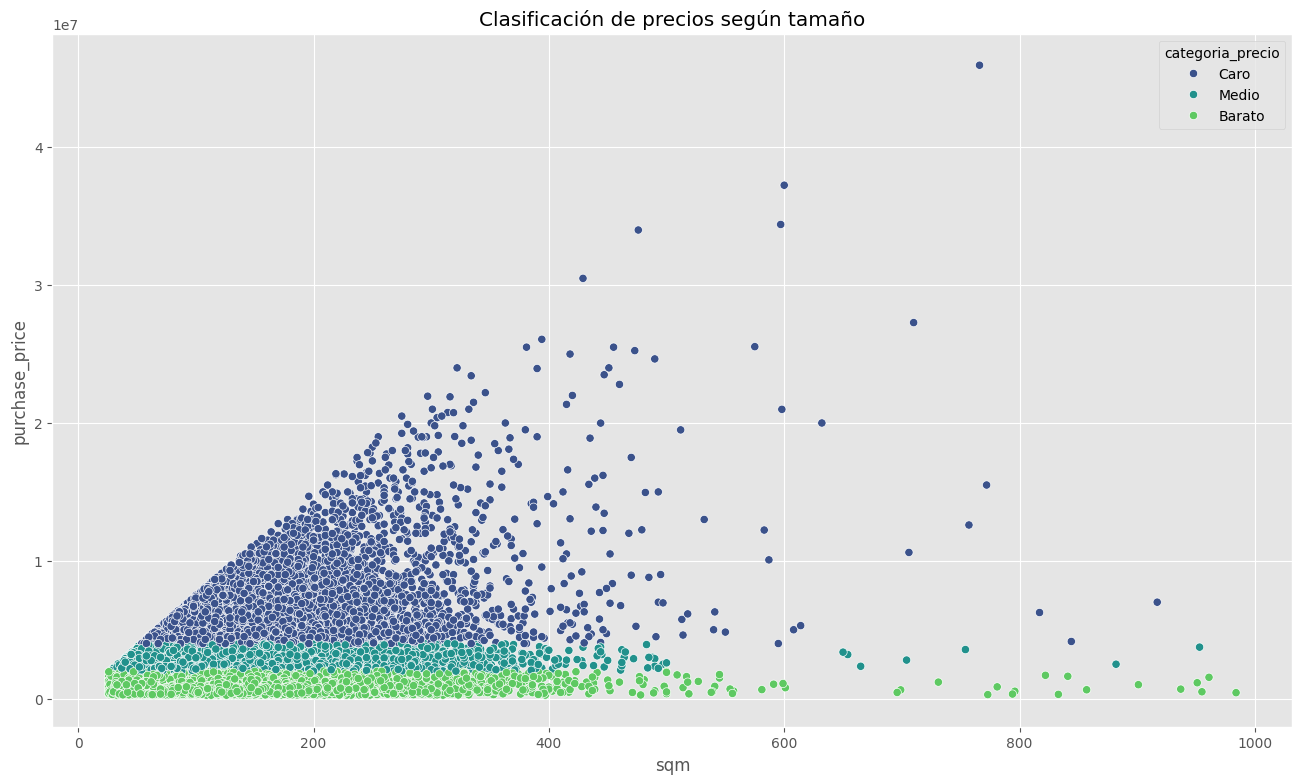

In [88]:
# Crear categorías de precio
def categorizar_precio(precio):
    if precio < 2000000:  # Barato
        return 'Barato'
    elif 2000000 <= precio < 4000000:  # Medio
        return 'Medio'
    else:  # Caro
        return 'Caro'

df_houses['categoria_precio'] = df_houses['purchase_price'].apply(categorizar_precio)

# Convertir categorías en valores numéricos
label_encoder = LabelEncoder()
df_houses['categoria_precio_encoded'] = label_encoder.fit_transform(df_houses['categoria_precio'])

# Asegurarse de que 'year_build' es un entero
df_houses['year_build'] = pd.to_numeric(df_houses['year_build'], errors='coerce')
df_houses = df_houses.dropna(subset=['year_build'])
df_houses['year_build'] = df_houses['year_build'].astype(int)

# Seleccionar características para el modelo
X = df_houses[['no_rooms', 'sqm', 'year_build', 'house_type']]
y = df_houses['categoria_precio_encoded']

# Convertir variables categóricas en dummies
X = pd.get_dummies(X, drop_first=True)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf.predict(X_test)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Gráfico con la clasificación
plt.figure(figsize=(16, 9))
sns.scatterplot(x='sqm', y='purchase_price', data=df_houses, hue='categoria_precio', palette='viridis')
plt.title('Clasificación de precios según tamaño')
plt.show()


### Predicción de probabilidad de venta

[[  123  2269]
 [  231 17377]]
              precision    recall  f1-score   support

           0       0.35      0.05      0.09      2392
           1       0.88      0.99      0.93     17608

    accuracy                           0.88     20000
   macro avg       0.62      0.52      0.51     20000
weighted avg       0.82      0.88      0.83     20000



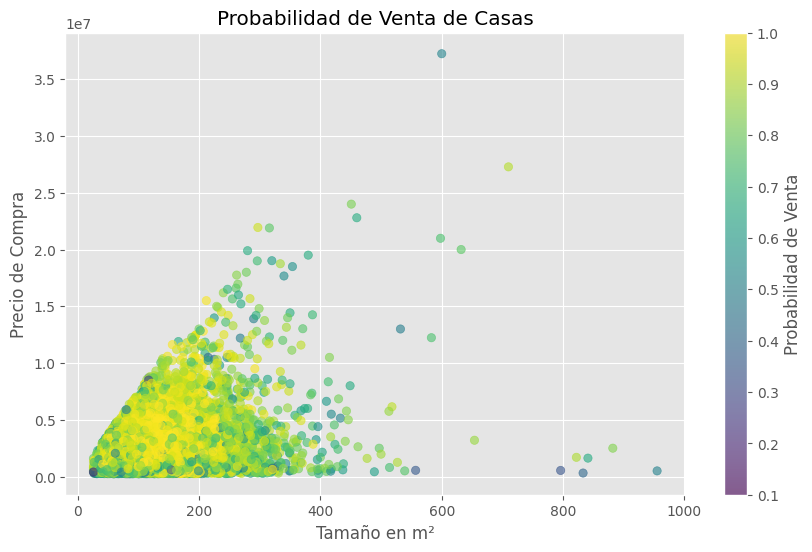

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Crear la columna 'sold' como objetivo (1: vendida, 0: no vendida)
df_houses['sold'] = df_houses['sales_type'].apply(lambda x: 1 if x == 'regular_sale' else 0)

# Seleccionar características y variable objetivo
features = ['year_build', 'no_rooms', 'sqm', 'purchase_price']
target = 'sold'

# Preparar los datos
X = df_houses[features]
y = df_houses[target]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Obtener probabilidades predichas
y_probs = model.predict_proba(X_test)[:, 1]

# Crear un DataFrame con los resultados
results = X_test.copy()
results['sold'] = y_test
results['prob_sold'] = y_probs

# Gráfico de las probabilidades de venta
plt.figure(figsize=(10, 6))
plt.scatter(results['sqm'], results['purchase_price'], c=results['prob_sold'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Probabilidad de Venta')
plt.xlabel('Tamaño en m²')
plt.ylabel('Precio de Compra')
plt.title('Probabilidad de Venta de Casas')
plt.show()